<a href="https://colab.research.google.com/github/wastb/Time-Forecasting/blob/master/notebooks/forecasting_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Objective***

- *to develop and evaluate time series forecasting models that predict future asset prices and market trends, with a focus on ARIMA, SARIMA, and LSTM models.*

- *Calculating evaluation metrics to assess the model's performance.*

- *Generate future price predictions, analyze the results, and provide insights on potential trends and risks.*

*Let's Dive In!*



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install pmdarima

## ***1. Libraries and Data Collection***

In [3]:
#Import necessary library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from pmdarima import auto_arima

from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.holtwinters import ExponentialSmoothing

# For reproducibility
import tensorflow as tf
tf.random.set_seed(42)
np.random.seed(42)

import warnings
warnings.filterwarnings('ignore')

In [4]:
#Load the cleaned datasets
df_tsla = pd.read_csv('/content/drive/MyDrive/TESLA.csv')
df_sp = pd.read_csv('/content/drive/MyDrive/SP.csv')
df_bnd = pd.read_csv('/content/drive/MyDrive/BND.csv')

In [5]:
#Change the date datatype
df_tsla['Date'] = pd.to_datetime(df_tsla['Date'])
df_sp['Date'] = pd.to_datetime(df_sp['Date'])
df_bnd['Date'] = pd.to_datetime(df_bnd['Date'])

In [6]:
#Set the Date column as the index
df_tsla.set_index('Date',inplace=True)
df_sp.set_index('Date',inplace=True)
df_bnd.set_index('Date',inplace=True)

In [7]:
#Resample the data into monthly data to make it simpler for analysis
df_tsla_monthly = df_tsla.resample('M').mean()
df_sp_monthly = df_sp.resample('M').mean()
df_bnd_monthly = df_bnd.resample('M').mean()

In [8]:
#Let's filter only the required feature
tsla_close = df_tsla_monthly['Adj Close']
sp_close = df_sp_monthly['Adj Close']
bnd_close = df_bnd_monthly['Adj Close']

## ***2. Stationarity***

In [9]:
#Perform the Augmented Dickey-Fuller test
def ad_fuller(close):
    result_original = adfuller(close)

    print('++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
    print(f"ADF Statistic (Original): {result_original[0]:.4f}")
    print(f"p-value (Original): {result_original[1]:.4f}")

    if result_original[1] < 0.05:
        print("Interpretation: The series is Stationary.\n")
    else:
        print("Interpretation: The series is Non-Stationary.\n")
    print('++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')

In [10]:
#Check stationarity
ad_fuller(tsla_close)
ad_fuller(sp_close)
ad_fuller(bnd_close)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
ADF Statistic (Original): -0.0794
p-value (Original): 0.9515
Interpretation: The series is Non-Stationary.

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
ADF Statistic (Original): 1.4871
p-value (Original): 0.9975
Interpretation: The series is Non-Stationary.

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
ADF Statistic (Original): -1.6735
p-value (Original): 0.4448
Interpretation: The series is Non-Stationary.

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


## ***3.Train-Test Split***

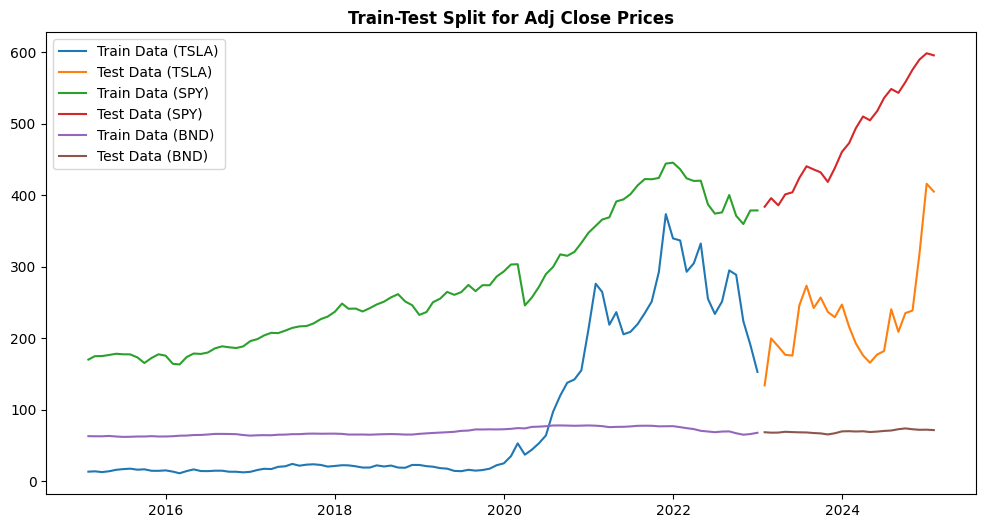

In [11]:
#Split the data for training and test
split_ratio = int(len(tsla_close)*0.8)

train_tsla, test_tsla = tsla_close[:split_ratio], tsla_close[split_ratio:]
train_sp, test_sp = sp_close[:split_ratio], sp_close[split_ratio:]
train_bnd, test_bnd = bnd_close[:split_ratio], bnd_close[split_ratio:]

plt.figure(figsize=(12, 6))
plt.plot(train_tsla, label='Train Data (TSLA)')
plt.plot(test_tsla, label='Test Data (TSLA)')
plt.plot(train_sp, label='Train Data (SPY)')
plt.plot(test_sp, label='Test Data (SPY)')
plt.plot(train_bnd, label='Train Data (BND)')
plt.plot(test_bnd, label='Test Data (BND)')
plt.legend()
plt.title("Train-Test Split for Adj Close Prices",fontsize=12, fontweight='bold')
plt.show()

## ***3.Auto-ARIMA***

### ***3.1. TSLA***

In [12]:
#Fit the model for TSLA
model_tsla = auto_arima(train_tsla, start_p = 1, start_q = 1,
                          max_p = 10, max_q = 10, m = 12,
                          start_P = 0, seasonal = True,
                          d = None, D = 1, trace = True,
                          error_action ='ignore',   # we don't want to know if an order does not work
                          suppress_warnings = True,  # we don't want convergence warnings
                          stepwise = True)           # set to stepwise
print(model_tsla.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=763.971, Time=0.83 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=790.184, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=768.707, Time=0.25 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=761.982, Time=1.48 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=774.470, Time=0.14 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=763.937, Time=1.45 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=763.922, Time=1.45 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=765.831, Time=0.44 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=765.728, Time=1.74 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=770.818, Time=0.65 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=763.958, Time=1.04 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=764.656, Time=1.07 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=765.763, Time=1.87 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=763.868, Time=1.51 sec

Best model:  ARIMA(0,1,1)(0,1,1)

In [13]:
#build and fit the model
arima_model_tsla = SARIMAX(train_tsla, order=(1, 2, 1), seasonal_order=(0, 1, 1, 12))
result_tsla= arima_model_tsla.fit()
print(result_tsla.summary())

                                     SARIMAX Results                                      
Dep. Variable:                          Adj Close   No. Observations:                   96
Model:             SARIMAX(1, 2, 1)x(0, 1, 1, 12)   Log Likelihood                -377.216
Date:                            Mon, 03 Mar 2025   AIC                            762.432
Time:                                    08:34:31   BIC                            772.059
Sample:                                01-31-2015   HQIC                           766.297
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2648      0.114      2.332      0.020       0.042       0.487
ma.L1         -0.9051      0.079   

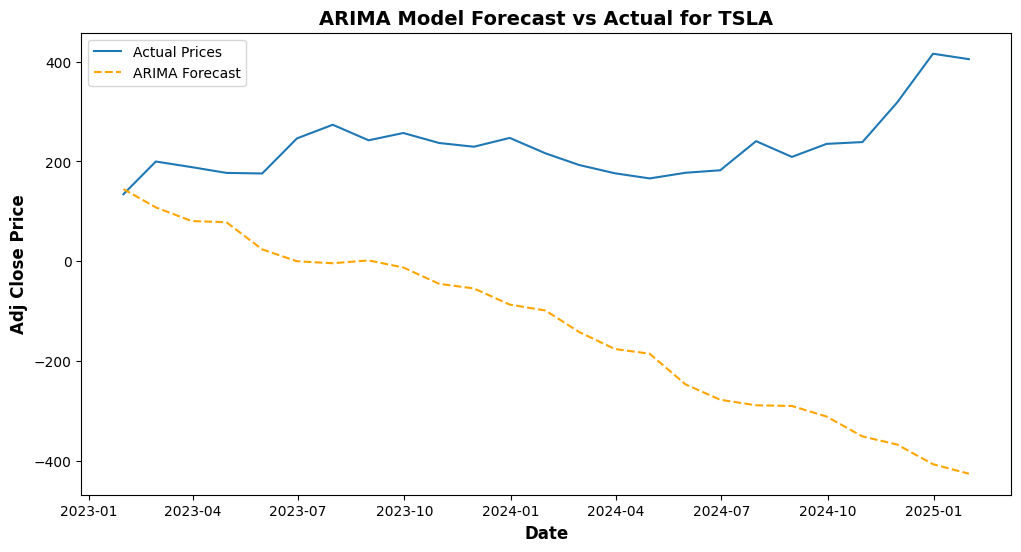

In [14]:
#Forecast for the test data
arima_forecast_tsla = result_tsla.predict(start=test_tsla.index[0], end=test_tsla.index[-1])

# Plot actual vs ARIMA forecast for each ticker
plt.figure(figsize=(12, 6))
plt.plot(test_tsla.index, test_tsla.values, label=f'Actual Prices')
plt.plot(test_tsla.index, arima_forecast_tsla, label=f'ARIMA Forecast', linestyle='--', color='orange')
plt.title("ARIMA Model Forecast vs Actual for TSLA",fontsize=14, fontweight='bold')
plt.xlabel("Date",fontsize=12, fontweight='bold')
plt.ylabel("Adj Close Price",fontsize=12, fontweight='bold')
plt.legend()
plt.show()

### ***3.2. SPY***

In [15]:
#Fit the model for SPY
model_sp = auto_arima(train_sp, start_p = 1, start_q = 1,
                          max_p = 10, max_q = 10, m = 12,
                          start_P = 0, seasonal = True,
                          d = None, D = 1, trace = True,
                          error_action ='ignore',   # we don't want to know if an order does not work
                          suppress_warnings = True,  # we don't want convergence warnings
                          stepwise = True)           # set to stepwise
print(model_sp.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=670.100, Time=2.61 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=867.388, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=680.762, Time=1.60 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=3.35 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=903.591, Time=0.07 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=691.040, Time=1.34 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=671.883, Time=4.22 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=671.933, Time=0.92 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=677.985, Time=0.45 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=2.00 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=671.335, Time=0.33 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=672.024, Time=0.52 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=671.987, Time=0.55 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,0,2)(0,1,1)[12] intercept   : AIC=in

In [16]:
#Fit the model
arima_model_sp = SARIMAX(train_sp, order=(1, 0, 1), seasonal_order=(0, 1, 1, 12))
result_sp = arima_model_sp.fit()
print(result_sp.summary())

                                     SARIMAX Results                                      
Dep. Variable:                          Adj Close   No. Observations:                   96
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -331.712
Date:                            Mon, 03 Mar 2025   AIC                            671.424
Time:                                    08:34:53   BIC                            681.147
Sample:                                01-31-2015   HQIC                           675.333
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9833      0.020     50.074      0.000       0.945       1.022
ma.L1          0.2160      0.084   

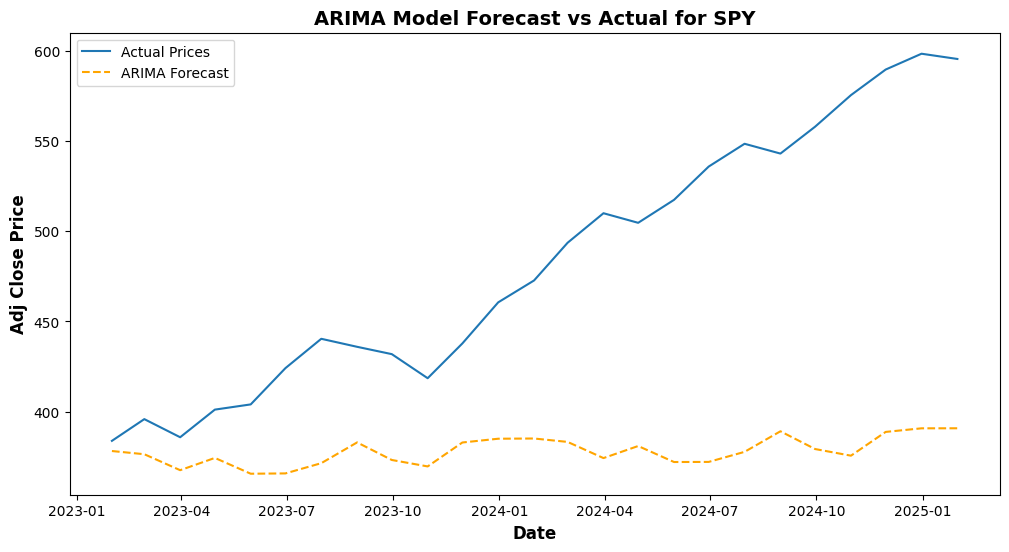

In [17]:
#forecast for the test data
arima_forecast_sp = result_sp.predict(start=test_sp.index[0], end=test_sp.index[-1])

# Plot actual vs ARIMA forecast values
plt.figure(figsize=(12, 6))
plt.plot(test_sp.index, test_sp.values, label=f'Actual Prices')
plt.plot(test_sp.index, arima_forecast_sp, label=f'ARIMA Forecast', linestyle='--', color='orange')
plt.title("ARIMA Model Forecast vs Actual for SPY",fontsize=14, fontweight='bold')
plt.xlabel("Date",fontsize=12, fontweight='bold')
plt.ylabel("Adj Close Price",fontsize=12, fontweight='bold')
plt.legend()
plt.show()

### ***3.3. BND***

In [18]:
#Fit the model for SPY
model_bnd = auto_arima(train_bnd, start_p = 1, start_q = 1,
                          max_p = 10, max_q = 10, m = 12,
                          start_P = 0, seasonal = True,
                          d = None, D = 1, trace = True,
                          error_action ='ignore',   # we don't want to know if an order does not work
                          suppress_warnings = True,  # we don't want convergence warnings
                          stepwise = True)           # set to stepwise
print(model_bnd.summary())

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,1,1)[12]             : AIC=200.871, Time=0.31 sec
 ARIMA(0,2,0)(0,1,0)[12]             : AIC=230.621, Time=0.04 sec
 ARIMA(1,2,0)(1,1,0)[12]             : AIC=215.984, Time=0.09 sec
 ARIMA(0,2,1)(0,1,1)[12]             : AIC=201.199, Time=0.16 sec
 ARIMA(1,2,1)(0,1,0)[12]             : AIC=206.147, Time=0.09 sec
 ARIMA(1,2,1)(1,1,1)[12]             : AIC=202.249, Time=0.36 sec
 ARIMA(1,2,1)(0,1,2)[12]             : AIC=201.238, Time=1.25 sec
 ARIMA(1,2,1)(1,1,0)[12]             : AIC=205.390, Time=0.79 sec
 ARIMA(1,2,1)(1,1,2)[12]             : AIC=202.732, Time=2.50 sec
 ARIMA(1,2,0)(0,1,1)[12]             : AIC=211.578, Time=0.13 sec
 ARIMA(2,2,1)(0,1,1)[12]             : AIC=202.861, Time=0.76 sec
 ARIMA(1,2,2)(0,1,1)[12]             : AIC=202.763, Time=0.75 sec
 ARIMA(0,2,0)(0,1,1)[12]             : AIC=221.518, Time=0.13 sec
 ARIMA(0,2,2)(0,1,1)[12]             : AIC=200.983, Time=0.28 sec
 ARIMA(2,2,0)(0,1,1)[12]         

In [19]:
#Fit the model
arima_model_bnd = SARIMAX(train_bnd, order=(0, 1, 1), seasonal_order=(0, 1, 1, 12))
result_bnd = arima_model_bnd.fit()
print(result_bnd.summary())

                                     SARIMAX Results                                      
Dep. Variable:                          Adj Close   No. Observations:                   96
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 -98.094
Date:                            Mon, 03 Mar 2025   AIC                            202.187
Time:                                    08:35:03   BIC                            209.444
Sample:                                01-31-2015   HQIC                           205.103
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3472      0.117      2.969      0.003       0.118       0.576
ma.S.L12      -0.5468      0.210   

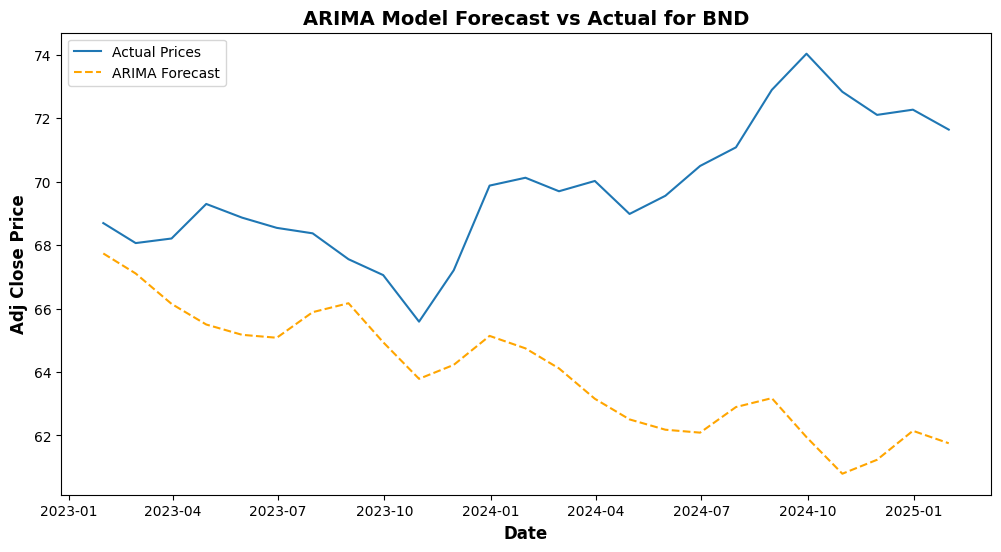

In [20]:
#forecast for the test data
arima_forecast_bnd = result_bnd.predict(start=test_bnd.index[0], end=test_bnd.index[-1])

# Plot actual vs ARIMA forecast values
plt.figure(figsize=(12, 6))
plt.plot(test_bnd.index, test_bnd.values, label=f'Actual Prices')
plt.plot(test_bnd.index, arima_forecast_bnd, label=f'ARIMA Forecast', linestyle='--', color='orange')
plt.title("ARIMA Model Forecast vs Actual for BND",fontsize=14, fontweight='bold')
plt.xlabel("Date",fontsize=12, fontweight='bold')
plt.ylabel("Adj Close Price",fontsize=12, fontweight='bold')
plt.legend()
plt.show()

## ***4. LSTM***

In [21]:
#Function to create LSTM Sequence
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

In [22]:
#LSTM Model
def build_lstm_model(X_train):
    model = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
        Dropout(0.2),
        LSTM(units=50, return_sequences=False),
        Dropout(0.2),
        Dense(units=25),
        Dense(units=1)  # Output layer
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.summary()

    return model

### ***4.1. TSLA***

In [23]:
#Scale the data
scaler_tsla = MinMaxScaler(feature_range=(0, 1))
scaled_data_tsla = scaler_tsla.fit_transform(df_tsla[['Adj Close']])

In [24]:
#Train-Test Split
train_size = int(len(scaled_data_tsla) * 0.8)
train_data_tsla = scaled_data_tsla[:train_size]
test_data_tsla = scaled_data_tsla[train_size:]

In [25]:
#Create sequence
X_train_tsla, y_train_tsla = create_sequences(train_data_tsla)
X_test_tsla, y_test_tsla = create_sequences(test_data_tsla)

In [26]:
#train the model for tsla data
model_tsla = build_lstm_model(X_train_tsla)
history_tsla = model_tsla.fit(X_train_tsla, y_train_tsla, epochs=10, batch_size=32, validation_data=(X_test_tsla, y_test_tsla))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.0162 - val_loss: 0.0027
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 9/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9.2550e-04 - val_loss: 0.0012
Epoch 10/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.8820e-04 - val_loss: 0.0013


In [27]:
# Predict on test data
predictions_tsla = model_tsla.predict(X_test_tsla)

# Reverse the scaling
predictions_tsla = scaler_tsla.inverse_transform(predictions_tsla)
y_test_actual_tsla = scaler_tsla.inverse_transform(y_test_tsla.reshape(-1, 1))

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


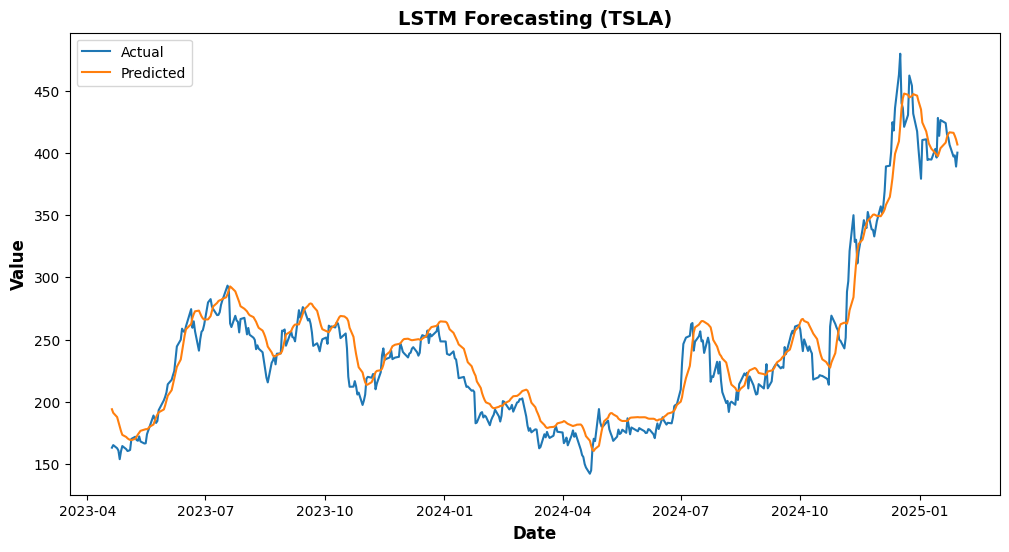

In [28]:
#Plot the predicted
plt.figure(figsize=(12,6))
plt.plot(df_tsla.index[train_size + 60:], y_test_actual_tsla, label="Actual")
plt.plot(df_tsla.index[train_size + 60:], predictions_tsla, label="Predicted")
plt.xlabel("Date",fontsize=12, fontweight='bold')
plt.ylabel("Value",fontsize=12, fontweight='bold')
plt.title("LSTM Forecasting (TSLA)",fontsize=14, fontweight='bold')
plt.legend()
plt.show()

### ***4.2. SPY***

In [29]:
#Scale the data
scaler_spy = MinMaxScaler(feature_range=(0, 1))
scaled_data_sp = scaler_spy.fit_transform(df_sp[['Adj Close']])

In [30]:
#Train-Test Split
train_size = int(len(scaled_data_sp) * 0.8)
train_data_sp = scaled_data_sp[:train_size]
test_data_sp = scaled_data_sp[train_size:]

In [31]:
#Create sequence
X_train_sp, y_train_sp = create_sequences(train_data_sp)
X_test_sp, y_test_sp = create_sequences(test_data_sp)

In [32]:
#train the model for tsla data
model_sp = build_lstm_model(X_train_sp)
history_sp = model_sp.fit(X_train_sp, y_train_sp, epochs=10, batch_size=32, validation_data=(X_test_sp, y_test_sp))

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0208 - val_loss: 6.6505e-04
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0013 - val_loss: 7.9981e-04
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0010 - val_loss: 6.9661e-04
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0010 - val_loss: 0.0019
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 8.4848e-04 - val_loss: 7.0979e-04
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.6211e-04 - val_loss: 9.5555e-04
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.7932e-04 - val_loss: 5.8977e-04
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.6755e-04 - val_loss: 5.5052e-04
Epoch 9/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.0642e-04 - val_loss: 3.6578e-04
Epoch 10/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.7392e-04 - val_loss: 0.0016


In [33]:
# Predict on test data
predictions_sp = model_sp.predict(X_test_sp)

# Reverse the scaling
predictions_sp= scaler_spy.inverse_transform(predictions_sp)
y_test_actual_sp = scaler_spy.inverse_transform(y_test_sp.reshape(-1, 1))

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


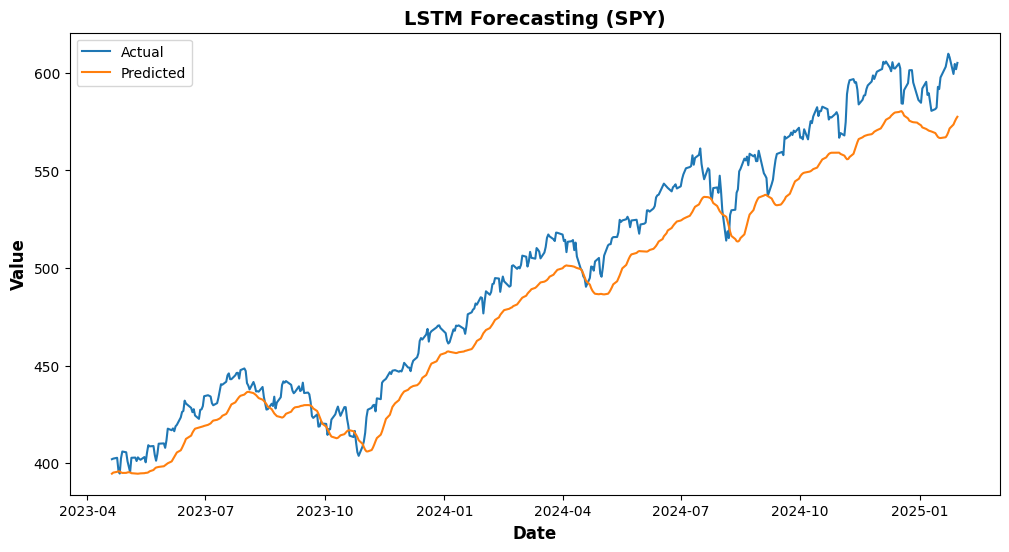

In [34]:
#Plot the predicted
plt.figure(figsize=(12,6))
plt.plot(df_sp.index[train_size + 60:], y_test_actual_sp, label="Actual")
plt.plot(df_sp.index[train_size + 60:], predictions_sp, label="Predicted")
plt.xlabel("Date",fontsize=12, fontweight='bold')
plt.ylabel("Value",fontsize=12, fontweight='bold')
plt.title("LSTM Forecasting (SPY)",fontsize=14, fontweight='bold')
plt.legend()
plt.show()

### ***4.3. BND***

In [35]:
#Scale the data
scaler_bnd = MinMaxScaler(feature_range=(0, 1))
scaled_data_bnd = scaler_bnd.fit_transform(df_bnd[['Adj Close']])

In [36]:
#Train-Test Split
train_size = int(len(scaled_data_bnd) * 0.8)
train_data_bnd = scaled_data_bnd[:train_size]
test_data_bnd = scaled_data_bnd[train_size:]

In [37]:
#Create sequence
X_train_bnd, y_train_bnd = create_sequences(train_data_bnd)
X_test_bnd, y_test_bnd = create_sequences(test_data_bnd)

In [38]:
#train the model for tsla data
model_bnd = build_lstm_model(X_train_bnd)
history_bnd = model_bnd.fit(X_train_bnd, y_train_bnd, epochs=10, batch_size=32, validation_data=(X_test_bnd, y_test_bnd))

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0345 - val_loss: 0.0011
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0038 - val_loss: 0.0013
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0028 - val_loss: 9.7719e-04
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0029 - val_loss: 0.0012
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0028 - val_loss: 0.0015
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0031 - val_loss: 0.0018
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0026 - val_loss: 0.0014
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0024 - val_loss: 9.9709e-04
Epoch 9/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0023 - val_loss: 0.0012
Epoch 10/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0020 - val_loss: 9.8493e-04


In [39]:
# Predict on test data
predictions_bnd = model_bnd.predict(X_test_bnd)

# Reverse the scaling
predictions_bnd= scaler_bnd.inverse_transform(predictions_bnd)
y_test_actual_bnd = scaler_bnd.inverse_transform(y_test_bnd.reshape(-1, 1))

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


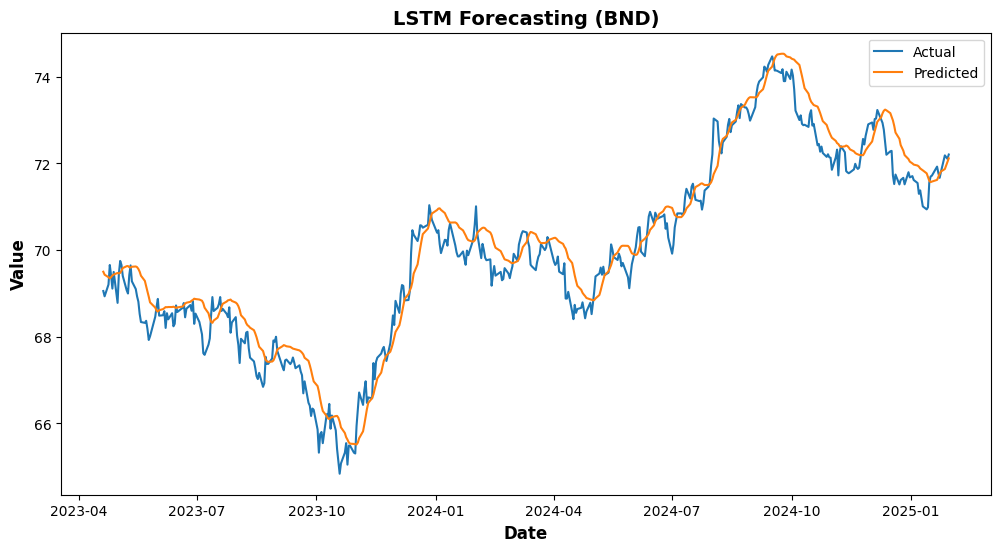

In [40]:
#Plot the predicted
plt.figure(figsize=(12,6))
plt.plot(df_bnd.index[train_size + 60:], y_test_actual_bnd, label="Actual")
plt.plot(df_bnd.index[train_size + 60:], predictions_bnd, label="Predicted")
plt.xlabel("Date",fontsize=12, fontweight='bold')
plt.ylabel("Value",fontsize=12, fontweight='bold')
plt.title("LSTM Forecasting (BND)",fontsize=14, fontweight='bold')
plt.legend()
plt.show()

## ***5. Model Evaluation and Comparison***

In [41]:
# Define function to calculate evaluation metrics
def calculate_metrics(actual, forecast):
    mae = mean_absolute_error(actual, forecast)
    # Calculate MSE and then take the square root for RMSE
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    mape = mean_absolute_percentage_error(actual, forecast)
    return mae, rmse, mape

In [42]:
#Evaluate the models for TSLA
# Evaluate models
sarima_mae, sarima_rmse, sarima_mape = calculate_metrics(test_tsla, arima_forecast_tsla)
lstm_mae, lstm_rmse, lstm_mape = calculate_metrics(y_test_actual_tsla, predictions_tsla)

# Print metrics
print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
print("SARIMA: MAE =", sarima_mae, ", RMSE =", sarima_rmse, ", MAPE =", sarima_mape)
print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
print("LSTM: MAE =", lstm_mae, ", RMSE =", lstm_rmse, ", MAPE =", lstm_mape)
print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
SARIMA: MAE = 365.7406182524959 , RMSE = 422.5152757106083 , MAPE = 1.5277919767428596
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
LSTM: MAE = 13.503073400032333 , RMSE = 17.06432792021569 , MAPE = 0.058746688232913874
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


#### ***OBSERVATION***

*It's clear from the Evaluation metrics and graphs that the LSTM model outperforms the SARIMAX model*

## ***6. Future Predictions***

### ***6.1.TSLA***

In [43]:
future_steps = 365  # Forecasting for 12 months (365 days)
future_predictions_tsla = []

# Get the last 60 days from the dataset
last_sequence = X_test_tsla[-1]  # Shape (60, 1)

for _ in range(future_steps):
    # Reshape to fit LSTM input format
    last_sequence_reshaped = last_sequence.reshape(1, 60, 1)

    # Predict the next value
    next_pred = model_tsla.predict(last_sequence_reshaped, verbose=0)

    # Store the prediction
    future_predictions_tsla.append(next_pred[0][0])

    # Append the predicted value to the sequence and remove the first value
    last_sequence = np.append(last_sequence[1:], next_pred).reshape(60, 1)


In [44]:
#Inverse the scales for the predicted value
future_predictions = np.array(future_predictions_tsla).reshape(-1, 1)
future_predictions = scaler_tsla.inverse_transform(future_predictions)

In [45]:
#Create future dates
last_date = df_tsla.index[-1]  # Get the last date from original dataset
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_steps, freq='D')

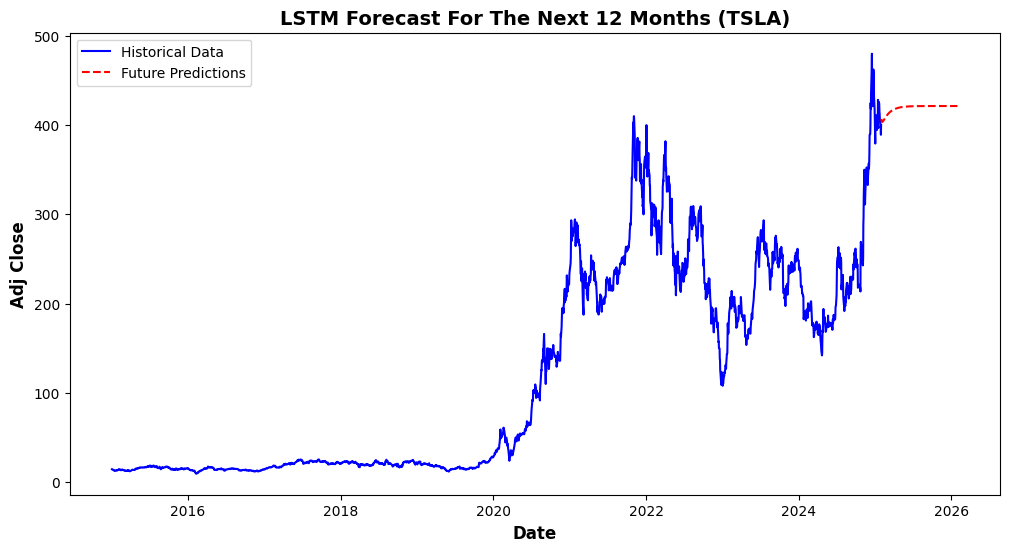

In [46]:
#Plot the future forecast and historical data
plt.figure(figsize=(12,6))
plt.plot(df_tsla.index, df_tsla['Adj Close'], label="Historical Data", color='blue')
plt.plot(future_dates, future_predictions, label="Future Predictions", color='red', linestyle='dashed')
plt.xlabel("Date",fontsize=12, fontweight='bold')
plt.ylabel("Adj Close",fontsize=12, fontweight='bold')
plt.title("LSTM Forecast For The Next 12 Months (TSLA)",fontsize=14, fontweight='bold')
plt.legend()
plt.show()

### ***6.2. SPY***

In [47]:
future_steps = 365  # Forecasting for 12 months (365 days)
future_predictions_sp= []

# Get the last 60 days from the dataset
last_sequence = X_test_sp[-1]  # Shape (60, 1)

for _ in range(future_steps):
    # Reshape to fit LSTM input format
    last_sequence_reshaped = last_sequence.reshape(1, 60, 1)

    # Predict the next value
    next_pred = model_sp.predict(last_sequence_reshaped, verbose=0)

    # Store the prediction
    future_predictions_sp.append(next_pred[0][0])

    # Append the predicted value to the sequence and remove the first value
    last_sequence = np.append(last_sequence[1:], next_pred).reshape(60, 1)

In [48]:
#Inverse the scales for the predicted value
future_predictions_sp = np.array(future_predictions_sp).reshape(-1, 1)
future_predictions_sp = scaler_spy.inverse_transform(future_predictions_sp)

In [49]:
#Create future dates
last_date_sp = df_sp.index[-1]  # Get the last date from original dataset
future_dates_sp = pd.date_range(start=last_date_sp + pd.Timedelta(days=1), periods=future_steps, freq='D')

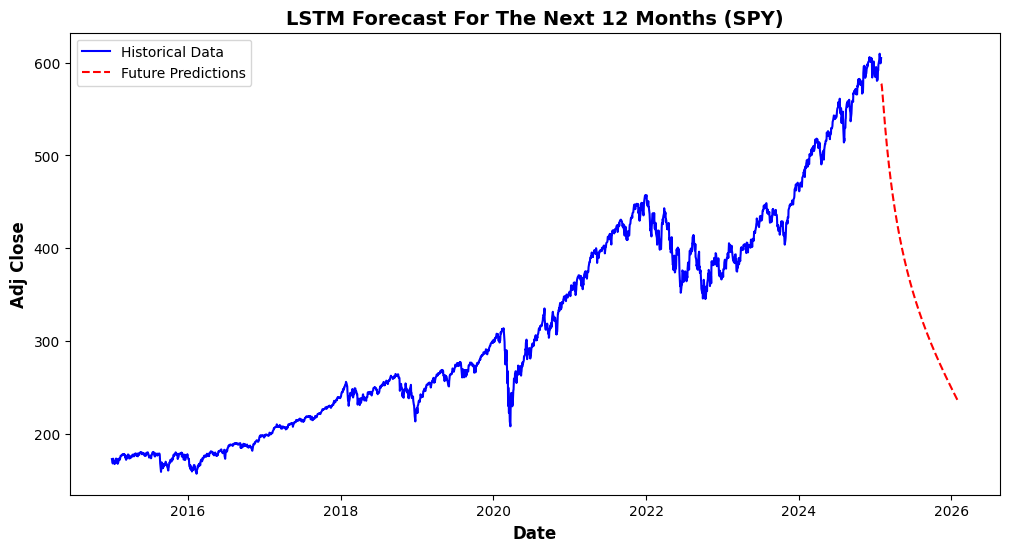

In [50]:
#Plot the future forecast and historical data
plt.figure(figsize=(12,6))
plt.plot(df_sp.index, df_sp['Adj Close'], label="Historical Data", color='blue')
plt.plot(future_dates_sp, future_predictions_sp, label="Future Predictions", color='red', linestyle='dashed')
plt.xlabel("Date",fontsize=12, fontweight='bold')
plt.ylabel("Adj Close",fontsize=12, fontweight='bold')
plt.title("LSTM Forecast For The Next 12 Months (SPY)",fontsize=14, fontweight='bold')
plt.legend()
plt.show()

### ***6.3. BND***

In [51]:
future_steps = 365  # Forecasting for 12 months (365 days)
future_predictions_bnd= []

# Get the last 60 days from the dataset
last_sequence = X_test_sp[-1]  # Shape (60, 1)

for _ in range(future_steps):
    # Reshape to fit LSTM input format
    last_sequence_reshaped = last_sequence.reshape(1, 60, 1)

    # Predict the next value
    next_pred = model_bnd.predict(last_sequence_reshaped, verbose=0)

    # Store the prediction
    future_predictions_bnd.append(next_pred[0][0])

    # Append the predicted value to the sequence and remove the first value
    last_sequence = np.append(last_sequence[1:], next_pred).reshape(60, 1)

In [52]:
#Inverse the scales for the predicted value
future_predictions_bnd = np.array(future_predictions_bnd).reshape(-1, 1)
future_predictions_bnd = scaler_bnd.inverse_transform(future_predictions_bnd)

In [53]:
#Create future dates
last_date_bnd = df_bnd.index[-1]  # Get the last date from original dataset
future_dates_bnd = pd.date_range(start=last_date_bnd + pd.Timedelta(days=1), periods=future_steps, freq='D')

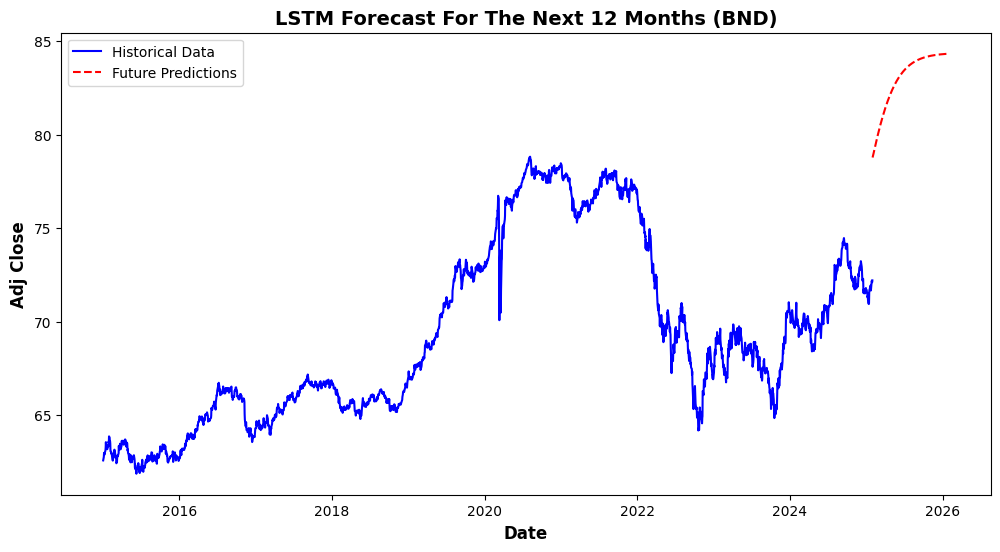

In [54]:
#Plot the future forecast and historical data
plt.figure(figsize=(12,6))
plt.plot(df_bnd.index, df_bnd['Adj Close'], label="Historical Data", color='blue')
plt.plot(future_dates_bnd, future_predictions_bnd, label="Future Predictions", color='red', linestyle='dashed')
plt.xlabel("Date",fontsize=12, fontweight='bold')
plt.ylabel("Adj Close",fontsize=12, fontweight='bold')
plt.title("LSTM Forecast For The Next 12 Months (BND)",fontsize=14, fontweight='bold')
plt.legend()
plt.show()

## ***7. Export The Forecasted Data***

In [66]:
predictions_tsla_df = pd.DataFrame(future_predictions, index=future_dates, columns=['Adj Close'])
predictions_tsla_df.to_csv('predictions_tsla.csv')
predictions_sp_df = pd.DataFrame(future_predictions_sp, index=future_dates_sp, columns=['Adj Close'])
predictions_sp_df.to_csv('predictions_sp.csv')
predictions_bnd_df = pd.DataFrame(future_predictions_bnd, index=future_dates_bnd, columns=['Adj Close'])
predictions_bnd_df.to_csv('predictions_bnd.csv')